In [80]:
from ML_Preparation.Preprocessing_M import DataExtractor, DataPreprocessing

de = DataExtractor("D:/hka-aqm-m", "C:/Users/danie/building_M_data")

df = de.create_df()

No .dat files found in C:/Users/danie/building_M_data. 
 Trying to extract files from the original directory D:/hka-aqm-m
Read data successfully.
Data contains 979166 data points and 18 columns.


In [84]:
df["date_time"] = pd.to_datetime(df["date_time"])

In [86]:
df[df.device_id.str.contains("m101")].set_index("date_time")[["CO2"]].resample("1d").mean()

,CO2
date_time,
2022-07-13,583.351351
2022-07-14,534.093484
2022-07-15,511.263393
2022-07-16,406.733333
2022-07-17,433.028169
...,...
2023-09-22,423.076087
2023-09-23,408.150289
2023-09-24,426.785124


In [91]:
dp = DataPreprocessing(label = "CO2")

df_preprocessed = dp.preprocess_df(df, rolling_window = "3d", sample_time = "1d")

In [92]:
df_preprocessed[df_preprocessed.room_number == "m101"][["date_time", "CO2"]]

,date_time,CO2
25,2022-07-13,616.685714
31,2022-07-14,534.093484
41,2022-07-15,511.263393
48,2022-07-16,406.733333
59,2022-07-17,433.028169
...,...,...
5754,2023-09-22,422.447205
5772,2023-09-23,408.018072
5793,2023-09-24,426.785124
5820,2023-09-25,486.598425


In [42]:
df_preprocessed.columns

Index(['date_time', 'tmp', 'hum', 'CO2', 'VOC', 'vis', 'IR', 'BLE', 'rssi',
       'snr', 'tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'wpgt', 'pres',
       'room_number', 'time_diff_sec', 'tmp_diff', 'hum_diff', 'VOC_diff',
       'vis_diff', 'IR_diff', 'BLE_diff', 'tavg_diff', 'tmin_diff',
       'tmax_diff', 'prcp_diff', 'wdir_diff', 'wspd_diff', 'wpgt_diff',
       'pres_diff', 'time_diff_sec_per_sec', 'tmp_diff_per_sec',
       'hum_diff_per_sec', 'VOC_diff_per_sec', 'vis_diff_per_sec',
       'IR_diff_per_sec', 'BLE_diff_per_sec', 'tavg_diff_per_sec',
       'tmin_diff_per_sec', 'tmax_diff_per_sec', 'prcp_diff_per_sec',
       'wdir_diff_per_sec', 'wspd_diff_per_sec', 'wpgt_diff_per_sec',
       'pres_diff_per_sec', 'year', 'dayofweek', 'hour', 'season', 'color',
       'VOC_CO2_ratio'],
      dtype='object')

In [43]:
from ML_Preparation.Feature_Engineering import *

fe = FeatureEngineering(df_preprocessed.drop(columns = ["VOC_CO2_ratio"]), 
                        label = "CO2", 
                        categorical_features = ["season", "room_number", "dayofweek", "color"],
                        automated_feature_engineering = False)

X_train, y_train, X_test, y_test = fe.feature_engineering(skip_scale = True)

In [44]:
df_train = fe.X_train
df_train["CO2"] = fe.y_train

df_test = fe.X_test
df_test["CO2"] = fe.y_test

In [45]:
def transform_data_for_forecasting(data, label_name, n_in, n_out, dropna = True):
    n_vars = data.shape[1]

    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(data[[f"{label_name}"]].shift(-i))
        if i == 0:
            names += [f"{label_name}(t)"]
        else:
            names += [f"{label_name}(t+{i})"]
        # put it all together
        data_reframed = pd.concat(cols, axis=1)
        data_reframed.columns = names
        # drop rows with NaN values
        if dropna:
            data_reframed.dropna(inplace=True)

    return data_reframed

In [46]:
train_reframed = transform_data_for_forecasting(df_train, "CO2", 3, 3)
test_reframed = transform_data_for_forecasting(df_test, "CO2", 3, 3)

train_reframed

,tmp(t-3),hum(t-3),VOC(t-3),vis(t-3),IR(t-3),BLE(t-3),tavg(t-3),tmin(t-3),tmax(t-3),prcp(t-3),...,dayofweek_5(t-1),dayofweek_6(t-1),color_green(t-1),color_red(t-1),color_red_blinking(t-1),color_yellow(t-1),CO2(t-1),CO2(t),CO2(t+1),CO2(t+2)
date_time,,,,,,,,,,,,,,,,,,,,,
2022-06-20,25.167642,33.097784,450.531250,124.801136,49.480114,11.900568,15.75,11.1,20.15,0.0,...,True,False,True,False,False,False,503.500000,517.369624,508.611074,509.363949
2022-06-21,25.167642,33.097784,450.531250,124.801136,49.480114,11.900568,15.75,11.1,20.15,0.0,...,False,False,True,False,False,False,517.369624,508.611074,509.363949,502.117254
2022-06-22,25.075909,34.541818,451.000000,62.227273,12.272727,1.363636,16.10,11.2,20.70,0.0,...,False,False,True,False,False,False,508.611074,509.363949,502.117254,528.670572
2022-06-23,26.678038,44.120685,97.393817,6.250000,2.447581,0.000000,16.10,11.2,20.70,0.0,...,False,False,True,False,False,False,509.363949,502.117254,528.670572,522.644597
2022-06-24,26.256901,42.272026,103.732398,5.127760,2.074737,0.000000,16.10,11.2,20.70,0.0,...,False,False,True,False,False,False,502.117254,528.670572,522.644597,513.890932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-29,28.231785,36.081130,1218.990394,422.287572,154.330075,10.012921,16.10,11.2,20.70,0.0,...,False,False,True,False,False,False,438.754688,400.831034,479.774295,430.267241
2023-06-29,26.684155,38.304220,1688.649934,237.215423,114.069214,11.872657,16.10,11.2,20.70,0.0,...,False,False,True,False,False,False,400.831034,479.774295,430.267241,503.482668
2023-06-29,27.881412,36.385444,1279.576528,904.187487,352.599970,12.617816,16.10,11.2,20.70,0.0,...,False,False,True,False,False,False,479.774295,430.267241,503.482668,446.152414


In [47]:
df_train.tail()["CO2"]

date_time
2023-06-29    430.267241
2023-06-29    503.482668
2023-06-29    446.152414
2023-06-29    593.054711
2023-06-29    458.528375
Name: CO2, dtype: float64

In [48]:
from sklearn.preprocessing import StandardScaler

def transform_to_numpy_array(train_data, test_data, n_out):
    # split into train and test sets
    values_train = train_data.values
    values_test = test_data.values
    # split into input and outputs
    train = values_train[:, :]
    test = values_test[:, :]

    train_X, train_y = train[:, :-n_out], train[:, -n_out:]
    test_X, test_y = test[:, :-n_out], test[:, -n_out:]

    sc = StandardScaler()

    train_X = sc.fit_transform(train_X)
    test_X = sc.transform(test_X)

    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

    train_X = np.asarray(train_X).astype('float32')
    train_y = np.asarray(train_y).astype('float32')

    test_X = np.asarray(test_X).astype('float32')
    test_y = np.asarray(test_y).astype('float32')

    return train_X, train_y, test_X, test_y

train_X, train_y, test_X, test_y = transform_to_numpy_array(train_reframed, test_reframed, 3)


(5103, 1, 264) (5103, 3) (1272, 1, 264) (1272, 3)


In [49]:
train_X.shape

(5103, 1, 264)

Epoch 1/10


c:\Users\danie\anaconda3\envs\awp1\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



80/80 - 2s - 30ms/step - loss: 83035.9297
Epoch 2/10
80/80 - 0s - 2ms/step - loss: 51517.8008
Epoch 3/10
80/80 - 0s - 2ms/step - loss: 49945.1719
Epoch 4/10
80/80 - 0s - 2ms/step - loss: 47230.6055
Epoch 5/10
80/80 - 0s - 2ms/step - loss: 51222.6836
Epoch 6/10
80/80 - 0s - 2ms/step - loss: 49003.8555
Epoch 7/10
80/80 - 0s - 2ms/step - loss: 46380.5781
Epoch 8/10
80/80 - 0s - 2ms/step - loss: 46838.5469
Epoch 9/10
80/80 - 0s - 2ms/step - loss: 42665.2109
Epoch 10/10
80/80 - 0s - 2ms/step - loss: 40793.3672


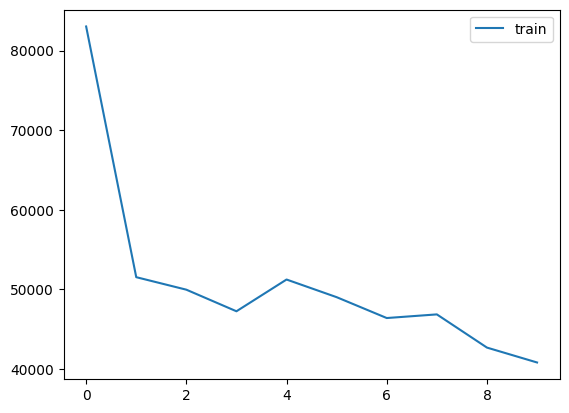

In [50]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, GRU, Dropout, Bidirectional
from keras.optimizers import Adam, SGD
from matplotlib import pyplot

class MyLSTMModel:
    def __init__(self,
                 n_out, 
                 lstm_units=100,
                 input_shape=(None, train_X.shape[-1]),
                 ):
        self.model = Sequential()
        self.model.add(LSTM(units=lstm_units, input_shape=input_shape, return_sequences = True, recurrent_dropout = 0.3))
        self.model.add(Dropout(0.3))
        self.model.add(Bidirectional(LSTM(units=lstm_units, recurrent_dropout = 0.3)))
        self.model.add(Dropout(0.3))
        self.model.add(Dense(50, activation = "relu"))
        self.model.add(Dropout(0.3))
        self.model.add(Dense(30, activation = "relu"))
        self.model.add(Dropout(0.3))
        self.model.add(Dense(15, activation = "relu"))
        self.model.add(Dropout(0.3))

        self.model.add(Dense(n_out))

        self.model.compile(optimizer=Adam(learning_rate = 0.05), loss='mse')
    
    def summary(self):
        self.model.summary()

# Instantiate the model
my_model = MyLSTMModel(3)

history = my_model.model.fit(train_X, train_y, epochs=10, batch_size=64, 
                             #validation_data=(test_X, test_y), 
                             verbose=2, 
                             #shuffle=False
                             )

pyplot.plot(history.history['loss'], label='train')
#pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [51]:
pred = my_model.model.predict(test_X)

pred

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


array([[454.35672, 462.2795 , 463.21008],
       [487.79047, 496.47476, 497.22617],
       [531.8992 , 541.4122 , 542.31665],
       ...,
       [598.9206 , 610.06976, 610.77844],
       [516.008  , 525.2767 , 526.0904 ],
       [686.69855, 699.8454 , 700.48157]], dtype=float32)

In [52]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, root_mean_squared_error, r2_score
import plotly.express as px
import seaborn as sns


class Evaluator:

    def __init__(self):
        pass

    def evaluate(self, y_pred, y_true):
        print("MSE: ", self.calculate_mse(y_pred = y_pred, y_true = y_true))
        print("RMSE: ", self.calculate_rmse(y_pred = y_pred, y_true = y_true))
        print("MAPE: ", self.calculate_mape(y_pred = y_pred, y_true = y_true))
        print("R2: ", self.calculate_r2(y_pred = y_pred, y_true = y_true))
        print("\n")


    def calculate_mse(self, y_true, y_pred):
        return round(mean_squared_error(y_true = y_true, y_pred = y_pred), 2)

    def calculate_rmse(self, y_true, y_pred):
        return round(root_mean_squared_error(y_true = y_true, y_pred = y_pred), 2)

    def calculate_mape(self, y_true, y_pred):
        return round(mean_absolute_percentage_error(y_true = y_true, y_pred = y_pred), 2)

    def calculate_r2(self, y_true, y_pred):
        return round(r2_score(y_true = y_true, y_pred = y_pred), 2)

ev = Evaluator()

for col in range(0, test_y.shape[1]):
    print(f"t +", col)
    ev.evaluate(y_true = test_y[:, col], y_pred = pred[:, col])

    pred_df = pd.DataFrame(pred[:, col], columns = [f"pred_CO2(t + {col})"])
    pred_df[f"CO2(t + {col})"] = test_y[:, col]

    px.line(y = [test_y[:, col], pred[:, col]], title = f"Prediction for CO2(t + {col})      blue = y_true, red = y_pred").show()


t + 0
MSE:  7091.04
RMSE:  84.21
MAPE:  0.11
R2:  -0.35




t + 1
MSE:  6810.95
RMSE:  82.53
MAPE:  0.11
R2:  -0.3




t + 2
MSE:  7187.8
RMSE:  84.78
MAPE:  0.11
R2:  -0.36


